In [1]:
import pandas as pd
import talib as ta
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import random
import math
import torch.nn.functional as F

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from numpy import mean

from matplotlib import pyplot as plt

In [2]:
###############This is to split the dataset between training and testing right the begining of any preprocessing#####
df1 = pd.read_csv('data/AUD_USD_M15.csv',skiprows = [x for x in range(360000,407401)])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device2 = torch.device('cpu')

In [3]:
df1

datetime     open     high      low    close
0       2005-01-02T18:45:00.000000000Z  0.78230  0.78230  0.78230  0.78230
1       2005-01-02T19:15:00.000000000Z  0.78200  0.78280  0.78180  0.78230
2       2005-01-02T19:45:00.000000000Z  0.78180  0.78180  0.78180  0.78180
3       2005-01-02T20:00:00.000000000Z  0.78140  0.78160  0.78060  0.78060
4       2005-01-02T20:15:00.000000000Z  0.78080  0.78130  0.78080  0.78090
...                                ...      ...      ...      ...      ...
359994  2019-04-02T04:15:00.000000000Z  0.70929  0.70929  0.70804  0.70816
359995  2019-04-02T04:30:00.000000000Z  0.70819  0.70823  0.70799  0.70800
359996  2019-04-02T04:45:00.000000000Z  0.70804  0.70820  0.70788  0.70798
359997  2019-04-02T05:00:00.000000000Z  0.70802  0.70840  0.70792  0.70833
359998  2019-04-02T05:15:00.000000000Z  0.70830  0.70833  0.70798  0.70819

[359999 rows x 5 columns]

In [4]:
#########Generate features for training dataset############
df1['rsi'] = ta.RSI(df1['close'],14)
df1['MULT'] = ta.MULT(df1['high'],df1['low'])
df1['ROC'] = ta.ROC(df1['close'],timeperiod=10)
df1['PLUS_DM'] = ta.PLUS_DM(df1['high'],df1['low'],timeperiod=14)
df1['ADD'] = ta.ADD(df1['high'],df1['low'])
df1['CDLCONCEALBABYSWALL'] = ta.CDLCONCEALBABYSWALL(df1['open'],df1['high'],df1['low'],df1['close'])
print(df1.isna().sum().sum())
df1 = df1.fillna(0)

37


In [5]:
len(df1[:])

359999

In [6]:
############This is for Test dataset###############

df2= pd.read_csv('data/AUD_USD_M15.csv',skiprows = [x for x in range(1,360100)])
df2

datetime     open     high      low    close
0      2019-04-03T06:30:00.000000000Z  0.71128  0.71178  0.71114  0.71154
1      2019-04-03T06:45:00.000000000Z  0.71158  0.71172  0.71128  0.71159
2      2019-04-03T07:00:00.000000000Z  0.71156  0.71172  0.71128  0.71138
3      2019-04-03T07:15:00.000000000Z  0.71134  0.71158  0.71124  0.71147
4      2019-04-03T07:30:00.000000000Z  0.71150  0.71160  0.71076  0.71116
...                               ...      ...      ...      ...      ...
47296  2021-02-28T22:30:00.000000000Z  0.77134  0.77135  0.77082  0.77134
47297  2021-02-28T22:45:00.000000000Z  0.77129  0.77232  0.77125  0.77203
47298  2021-02-28T23:00:00.000000000Z  0.77210  0.77337  0.77140  0.77294
47299  2021-02-28T23:15:00.000000000Z  0.77290  0.77483  0.77258  0.77469
47300  2021-02-28T23:30:00.000000000Z  0.77466  0.77591  0.77432  0.77564

[47301 rows x 5 columns]

In [7]:
####Generate features for Test dataset################

df2['rsi'] = ta.RSI(df2['close'],14)
df2['MULT'] = ta.MULT(df2['high'],df2['low'])
df2['ROC'] = ta.ROC(df2['close'],timeperiod=10)
df2['PLUS_DM'] = ta.PLUS_DM(df2['high'],df2['low'],timeperiod=14)
df2['ADD'] = ta.ADD(df2['high'],df2['low'])
df2['CDLCONCEALBABYSWALL'] = ta.CDLCONCEALBABYSWALL(df2['open'],df2['high'],df2['low'],df2['close'])
print(df2.isna().sum().sum())
df2 = df2.fillna(0)
df_holdout=df2
df_holdout.reset_index(drop=True, inplace=True)

37


In [8]:
df_holdout

datetime     open     high      low    close  \
0      2019-04-03T06:30:00.000000000Z  0.71128  0.71178  0.71114  0.71154   
1      2019-04-03T06:45:00.000000000Z  0.71158  0.71172  0.71128  0.71159   
2      2019-04-03T07:00:00.000000000Z  0.71156  0.71172  0.71128  0.71138   
3      2019-04-03T07:15:00.000000000Z  0.71134  0.71158  0.71124  0.71147   
4      2019-04-03T07:30:00.000000000Z  0.71150  0.71160  0.71076  0.71116   
...                               ...      ...      ...      ...      ...   
47296  2021-02-28T22:30:00.000000000Z  0.77134  0.77135  0.77082  0.77134   
47297  2021-02-28T22:45:00.000000000Z  0.77129  0.77232  0.77125  0.77203   
47298  2021-02-28T23:00:00.000000000Z  0.77210  0.77337  0.77140  0.77294   
47299  2021-02-28T23:15:00.000000000Z  0.77290  0.77483  0.77258  0.77469   
47300  2021-02-28T23:30:00.000000000Z  0.77466  0.77591  0.77432  0.77564   

             rsi      MULT       ROC   PLUS_DM      ADD  CDLCONCEALBABYSWALL  
0       0.000000  0.506175  0.000000  0.000000  1.42292                    0  
1       0.000000  0.506232  0.000000  0.000000  1.42300                    0  
2       0.000000  0.506232  0.000000  0.000000  1.42300                    0  
3       0.000000  0.506104  0.000000  0.000000  1.42282                    0  
4       0.000000  0.505777  0.000000  0.000000  1.42236                    0  
...          ...       ...       ...       ...      ...                  ...  
47296  45.584208  0.594572  0.009076  0.002847  1.54217                    0  
47297  49.925204  0.595652  0.180370  0.003613  1.54357                    0  
47298  55.021413  0.596578  0.262025  0.004405  1.54477                    0  
47299  62.851263  0.598618  0.678389  0.005551  1.54741                    0  
47300  66.282661  0.600803  0.742934  0.006234  1.55023                    0  

[47301 rows x 11 columns]

In [9]:
############Define input sequence for deep learning model##################### 

def myfeature(feature_list,data_position,timestepback,timestepforward,future_outlook_window):
    # Future_outlook_window is set at minimium value of 1
    # timestepforward can be set as 0, this will impact the feature sequence/length
    # timestepback will decide n sessions of data that we used in feature in order to make predictions
    final=[]
    time_step_feature=[]
    for x in range(data_position-timestepback,data_position+timestepforward+1):
        feature=[]
        for aa in feature_list:
            feature.append(df1.iloc[x][aa])
        time_step_feature.append(feature)
    final.append(time_step_feature)
    final = torch.tensor(final).unsqueeze(0)
    
    target = df1.iloc[data_position+timestepforward+future_outlook_window]['close']
    
    mx=[]
    mn=[]
    for bb in range(future_outlook_window):
        mx.append(df1.iloc[data_position+timestepforward+bb+1]['high'])
        mn.append(df1.iloc[data_position+timestepforward+bb+1]['low'])
    max_price=max(mx)
    min_price=min(mn)
    
    
    
    
    
    return time_step_feature,target,max_price,min_price

In [10]:
############Define input sequence for Clustering##################### 

def myfeatureConventional(feature_list,data_position,timestepback,timestepforward,future_outlook_window):
    # Future_outlook_window is set at minimium value of 1
    # timestepforward can be set as 0, this will impact the feature sequence/length
    # timestepback will decide n sessions of data that we used in feature in order to make predictions
    final=[]
    time_step_feature=[]
    for x in range(data_position-timestepback,data_position+timestepforward+1):
        for aa in feature_list:
            time_step_feature.append(df1.iloc[x][aa])
    final.append(time_step_feature)
    
    target = df1.iloc[data_position+timestepforward+future_outlook_window]['close']
    
    mx=[]
    mn=[]
    for bb in range(future_outlook_window):
        mx.append(df1.iloc[data_position+timestepforward+bb+1]['high'])
        mn.append(df1.iloc[data_position+timestepforward+bb+1]['low'])
    max_price=max(mx)
    min_price=min(mn)
    
    
    
    
    
    return time_step_feature,target,max_price,min_price

In [11]:
###########Find oversold instance in training dataset###########
sample_index=[]
for x in range(14,len(df1['rsi'])-5):
    if df1['rsi'][x] <=30:
        sample_index.append(x)

random.shuffle(sample_index)
len(sample_index)

15123

In [12]:
max(sample_index)

359992

In [13]:
#create feature for deep leanring model:

training_features=['open','close','PLUS_DM','ADD','MULT','ROC']


dataset_deep = []
dataset_deep_label=[]

for x in sample_index[:]:
    feature,close,max_p,min_p = myfeature(training_features,x,9,0,4)
    dataset_deep.append(feature)
    dataset_deep_label.append(max_p)


In [14]:
#create feature for clustering:
training_features=['open','close','PLUS_DM','ADD','MULT','CDLCONCEALBABYSWALL']
dataset_convention=[]
dataset_convention_label=[]

for x in sample_index[:]:
    dataset_convention.append(myfeatureConventional(training_features,x,9,0,4)[0])


In [15]:
##########define input generation function for test data (deep learning model and clustering) 

def myfeature_test(feature_list,data_position,timestepback,timestepforward,future_outlook_window):
    # Future_outlook_window is set at minimium value of 1
    # timestepforward can be set as 0, this will impact the feature sequence/length
    # timestepback will decide n sessions of data that we used in feature in order to make predictions
    final=[]
    time_step_feature=[]
    for x in range(data_position-timestepback,data_position+timestepforward+1):
        feature=[]
        for aa in feature_list:
            feature.append(df_holdout.iloc[x][aa])
        time_step_feature.append(feature)
    final.append(time_step_feature)
    final = torch.tensor(final).unsqueeze(0)
    
    target = df_holdout.iloc[data_position+timestepforward+future_outlook_window]['close']
    
    mx=[]
    mn=[]
    for bb in range(future_outlook_window):
        mx.append(df_holdout.iloc[data_position+timestepforward+bb+1]['high'])
        mn.append(df_holdout.iloc[data_position+timestepforward+bb+1]['low'])
    max_price=max(mx)
    min_price=min(mn)
    
    
    
    
    
    return time_step_feature,target,max_price,min_price


def myfeatureConventional_test(feature_list,data_position,timestepback,timestepforward,future_outlook_window):#,label1,label2,label3):
    # Future_outlook_window is set at minimium value of 1
    # timestepforward can be set as 0, this will impact the feature sequence/length
    # timestepback will decide n sessions of data that we used in feature in order to make predictions
    final=[]
    time_step_feature=[]
    for x in range(data_position-timestepback,data_position+timestepforward+1):
        for aa in feature_list:
            time_step_feature.append(df_holdout.iloc[x][aa])
    final.append(time_step_feature)
    
    target = df_holdout.iloc[data_position+timestepforward+future_outlook_window]['close']
    
    mx=[]
    mn=[]
    for bb in range(future_outlook_window):
        mx.append(df_holdout.iloc[data_position+timestepforward+bb+1]['high'])
        mn.append(df_holdout.iloc[data_position+timestepforward+bb+1]['low'])
    max_price=max(mx)
    min_price=min(mn)
    
    
    
    
    
    return time_step_feature,target,max_price,min_price

In [16]:
###########find oversold instances in testdata and create input based on testdata############ 

sample_index2=[]
for x in range(14,len(df_holdout['rsi'])):
    if df_holdout['rsi'][x] <=30:
        sample_index2.append(x)

len(sample_index2)



training_features=['open','close','PLUS_DM','ADD','MULT','ROC']


dataset_deep2 = []
dataset_deep_label2=[]

for x in sample_index2[:]:
    feature,close,max_p,min_p = myfeature_test(training_features,x,9,0,4)
    dataset_deep2.append(feature)
    dataset_deep_label2.append(max_p)

In [17]:
#create feature based on testdata for clustering##############
training_features=['open','close','PLUS_DM','ADD','MULT','CDLCONCEALBABYSWALL']
dataset_convention2=[]
dataset_convention_label2=[]

for x in sample_index2[:]:
    dataset_convention2.append(myfeatureConventional_test(training_features,x,9,0,4)[0])


In [18]:
#########use kmeans to split training data into subgroups################

from sklearn.cluster import KMeans
testing = np.array(dataset_convention,dtype=float)
kmeans = KMeans(n_clusters=8, random_state=0).fit(testing)

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

In [24]:
###########this is to save and load kmeans model###########################################################################
import pickle

with open("k_means.pkl","wb") as f:
    pickle.dump(kmeans,f)

In [27]:
with open("k_means.pkl","rb") as f:
    L_Kmeans = pickle.load(f)
    
    
L_Kmeans.predict(testing)
Counter(L_Kmeans.labels_)

#############################################################################################################################

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

Counter({0: 1169,
         5: 1897,
         1: 4052,
         7: 2529,
         2: 1848,
         3: 1781,
         6: 1447,
         4: 400})

In [28]:
from collections import Counter
print(len(kmeans.labels_))
Counter(kmeans.labels_)

15123


Counter({0: 1169,
         5: 1897,
         1: 4052,
         7: 2529,
         2: 1848,
         3: 1781,
         6: 1447,
         4: 400})

In [29]:
clusters = Counter(kmeans.labels_)
cluster_no = max(clusters, key=clusters. get)

print(cluster_no)

1


In [30]:
a = kmeans.predict(np.array(dataset_convention2))
print(len(dataset_convention2))
print(len(a))


2121
2121


C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

In [31]:
ooo=0
for x in a:
    if x == cluster_no:
        ooo+=1
print(ooo)

184


In [32]:
###########################Define various models and training function################################

In [22]:
def sub_model_training(epoch,model,train_data,valid_data,loss_fun,lr,mydevice):
    epoch_list=[]
    train_loss=[]
    valid_loss=[]
    model.to(device)
    opt = torch.optim.Adam(model.parameters(),lr=0.01)
    opti_scheduler=torch.optim.lr_scheduler.StepLR(opt,step_size=400,gamma=0.95)
    for x in range(epoch):
        model.train()
        lose=0
        lose_target=0
        lose_max=0
        lose_min=0
        for a,b in train_data:
            a,b = a.to(mydevice),b.to(mydevice)
            opt.zero_grad()
            #close,maxi,mini = model(a)
            close = model(a)
            loss_close = loss_fun(close,b.view(-1,1),reduction='sum')###########################
            #loss_maxi = loss_fun(maxi,c.view(-1,1),reduction='sum')
            #loss_mini = loss_fun(mini,d.view(-1,1),reduction='sum')
            #total_loss = loss_close + loss_maxi + loss_mini
            lose += loss_close.item()
            #lose_max += loss_maxi.item()
            #lose_min += loss_mini.item()
            loss_close.backward()
            nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
            opt.step()
            opti_scheduler.step()
        print('epoch:{} with average training loss of {:.10f} and lr {}'.format(x+1,lose/training_len,opti_scheduler.get_last_lr()))
        epoch_list.append(x+1)
        train_loss.append(lose/training_no)
        
        with torch.no_grad():
            model.eval()
            lose2=0
            lose_target2=0
            lose_max2=0
            lose_min2=0
            for e,f in valid_data:
                e,f = e.to(device),f.to(device)
                close2 = model(e)
                loss_close2 = loss_fun(close2,f.view(-1,1),reduction='sum').item()
                #loss_maxi2 = loss_fun(maxi2,g.view(-1,1),reduction='sum').item()
                #loss_mini2 = loss_fun(mini2,h.view(-1,1),reduction='sum').item()
                #total_l = loss_close2+loss_maxi2+loss_mini2
                lose2 += loss_close2
        print('epoch:{} with average valid loss of {:.10f}'.format(x+1,lose2/validation_len))
        valid_loss.append(lose2/(validation_no))
    plt.figure(figsize=(20,8))        
    plt.plot(epoch_list[1:],train_loss[1:])
    plt.plot(epoch_list[1:],valid_loss[1:])
    plt.xlabel('no of epoch')
    plt.ylabel('average loss')
    plt.legend(['training loss','valid loss'])
    plt.grid()

    
def sub_model_output(model,data,device):
    with torch.no_grad():
        model.eval()
        output_close=[]
        output=[]
        for a,b in data:
            a = a.to(device)
            close = model(a)
            close=close.to(torch.device('cpu'))
            output_close.append(close.squeeze(1))
            output1 = [x for sublist in output_close for x in sublist]
            
        for x in range(len(output1)):
            output.append(output1[x])
        return output


In [23]:
class Encoder(nn.Module):
    def __init__(self,embedding_dim,enc_hidden_dim,dec_hidden_dim,dropout):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.enc_hidden_dim = enc_hidden_dim 
        self.dec_hidden_dim = dec_hidden_dim 
        self.rnn = nn.LSTM(embedding_dim,enc_hidden_dim,bidirectional=True,batch_first=True) 
        self.fc = nn.Linear(enc_hidden_dim * 2, dec_hidden_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self,source_data):
        outputs,(hidden,cell_state) = self.rnn(source_data)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:],hidden[-1,:,:]),dim=1))) 
        return outputs,hidden 


In [24]:
class Attention(nn.Module):
    def __init__(self,enc_hidden_dim,dec_hidden_dim):
        super().__init__()
        self.enc_hidden_dim = enc_hidden_dim
        self.dec_hidden_dim = dec_hidden_dim
        self.attn = nn.Linear((enc_hidden_dim*2) + dec_hidden_dim, dec_hidden_dim)


        self.vec = nn.Parameter(torch.rand(dec_hidden_dim))
        
    def forward(self,hidden,encoder_outputs): 

        
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        hidden = hidden.unsqueeze(1).repeat(1,src_len,1)

        
        encoder_outputs = encoder_outputs.permute(0,1,2)
        association = torch.tanh(self.attn(torch.cat((hidden,encoder_outputs),dim=2)))
        association = association.permute(0,2,1)
        vec = self.vec.repeat(batch_size,1).unsqueeze(1)
        attention = torch.bmm(vec,association).squeeze(1)
        return F.softmax(attention,dim=1)

In [25]:
class Decoder(nn.Module):
    def __init__(self,embedding_dim,enc_hid_dim,dec_hid_dim, dropout,attention): 
        super().__init__()
        self.embedding_dim = embedding_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.attention = attention
        self.rnn = nn.GRU((enc_hid_dim*2), dec_hid_dim,batch_first=True) 
        self.out = nn.Linear((enc_hid_dim*2)+ dec_hid_dim,1) 
        self.dropout = nn.Dropout(dropout)
    def forward(self,hidden,encoder_outputs):        
        a = self.attention(hidden,encoder_outputs)
        a = a.unsqueeze(1)
        encoder_outputs = encoder_outputs.permute(0,1,2)
        weighted = torch.bmm(a, encoder_outputs)
        weighted = weighted.permute(0,1,2)
        rnn_input = weighted
        output, hidden = self.rnn(rnn_input,hidden.unsqueeze(0))
        output2 = output.squeeze(1)
        weighted2 = weighted.squeeze(1)
        final_output = self.out(torch.cat((output2,weighted2),dim=1))
        return final_output, hidden.squeeze(0)

In [26]:
class Final_predictor(nn.Module):
    def __init__(self,encoder,decoder,device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self,source):
        encoder_outputs,hidden = self.encoder(source)
        output,hidden = self.decoder(hidden,encoder_outputs)
        
        return output

        

# Training our model using training data and evaluation on test data

4052
184
epoch:1 with average training loss of 0.0316040371 and lr [0.01]
epoch:1 with average valid loss of 0.0000837943
epoch:2 with average training loss of 0.0000827563 and lr [0.01]
epoch:2 with average valid loss of 0.0000661956
epoch:3 with average training loss of 0.0000705505 and lr [0.01]
epoch:3 with average valid loss of 0.0000378040
epoch:4 with average training loss of 0.0000641089 and lr [0.01]
epoch:4 with average valid loss of 0.0000329350
epoch:5 with average training loss of 0.0000644590 and lr [0.01]
epoch:5 with average valid loss of 0.0000588728
epoch:6 with average training loss of 0.0000627782 and lr [0.01]
epoch:6 with average valid loss of 0.0000288050
epoch:7 with average training loss of 0.0000579646 and lr [0.01]
epoch:7 with average valid loss of 0.0000257806
epoch:8 with average training loss of 0.0000502105 and lr [0.0095]
epoch:8 with average valid loss of 0.0000786488
epoch:9 with average training loss of 0.0000479287 and lr [0.0095]
epoch:9 with avera

epoch:67 with average training loss of 0.0000036042 and lr [0.006302494097246091]
epoch:67 with average valid loss of 0.0000009594
epoch:68 with average training loss of 0.0000036041 and lr [0.006302494097246091]
epoch:68 with average valid loss of 0.0000043785
epoch:69 with average training loss of 0.0000034693 and lr [0.006302494097246091]
epoch:69 with average valid loss of 0.0000222708
epoch:70 with average training loss of 0.0000187971 and lr [0.006302494097246091]
epoch:70 with average valid loss of 0.0000034445
epoch:71 with average training loss of 0.0000042129 and lr [0.006302494097246091]
epoch:71 with average valid loss of 0.0000017102
epoch:72 with average training loss of 0.0000148525 and lr [0.006302494097246091]
epoch:72 with average valid loss of 0.0000361849
epoch:73 with average training loss of 0.0000273506 and lr [0.005987369392383786]
epoch:73 with average valid loss of 0.0000102526
epoch:74 with average training loss of 0.0000091993 and lr [0.005987369392383786]
e

epoch:130 with average training loss of 0.0000073622 and lr [0.004181203352191771]
epoch:130 with average valid loss of 0.0000129302
epoch:131 with average training loss of 0.0000053579 and lr [0.003972143184582182]
epoch:131 with average valid loss of 0.0000007772
epoch:132 with average training loss of 0.0000030984 and lr [0.003972143184582182]
epoch:132 with average valid loss of 0.0000152172
epoch:133 with average training loss of 0.0000062325 and lr [0.003972143184582182]
epoch:133 with average valid loss of 0.0000012312
epoch:134 with average training loss of 0.0000015216 and lr [0.003972143184582182]
epoch:134 with average valid loss of 0.0000087153
epoch:135 with average training loss of 0.0000056321 and lr [0.003972143184582182]
epoch:135 with average valid loss of 0.0000065065
epoch:136 with average training loss of 0.0000061227 and lr [0.003972143184582182]
epoch:136 with average valid loss of 0.0000030208
epoch:137 with average training loss of 0.0000051387 and lr [0.003972

epoch:192 with average training loss of 0.0000014765 and lr [0.0026352009446574203]
epoch:192 with average valid loss of 0.0000068103
epoch:193 with average training loss of 0.0000027913 and lr [0.0026352009446574203]
epoch:193 with average valid loss of 0.0000122171
epoch:194 with average training loss of 0.0000044551 and lr [0.0026352009446574203]
epoch:194 with average valid loss of 0.0000123629
epoch:195 with average training loss of 0.0000047819 and lr [0.0026352009446574203]
epoch:195 with average valid loss of 0.0000052428
epoch:196 with average training loss of 0.0000020064 and lr [0.0026352009446574203]
epoch:196 with average valid loss of 0.0000151798
epoch:197 with average training loss of 0.0000047414 and lr [0.002503440897424549]
epoch:197 with average valid loss of 0.0000032600
epoch:198 with average training loss of 0.0000014762 and lr [0.002503440897424549]
epoch:198 with average valid loss of 0.0000025026
epoch:199 with average training loss of 0.0000011920 and lr [0.0

epoch:254 with average training loss of 0.0000019112 and lr [0.0017482461472379698]
epoch:254 with average valid loss of 0.0000017197
epoch:255 with average training loss of 0.0000013361 and lr [0.0016608338398760713]
epoch:255 with average valid loss of 0.0000110582
epoch:256 with average training loss of 0.0000025522 and lr [0.0016608338398760713]
epoch:256 with average valid loss of 0.0000013599
epoch:257 with average training loss of 0.0000011401 and lr [0.0016608338398760713]
epoch:257 with average valid loss of 0.0000045151
epoch:258 with average training loss of 0.0000014342 and lr [0.0016608338398760713]
epoch:258 with average valid loss of 0.0000066134
epoch:259 with average training loss of 0.0000022920 and lr [0.0016608338398760713]
epoch:259 with average valid loss of 0.0000073588
epoch:260 with average training loss of 0.0000025284 and lr [0.0016608338398760713]
epoch:260 with average valid loss of 0.0000017678
epoch:261 with average training loss of 0.0000015080 and lr [0

epoch:316 with average training loss of 0.0000010102 and lr [0.0011018311023500522]
epoch:316 with average valid loss of 0.0000016532
epoch:317 with average training loss of 0.0000010272 and lr [0.0011018311023500522]
epoch:317 with average valid loss of 0.0000006953
epoch:318 with average training loss of 0.0000007821 and lr [0.0011018311023500522]
epoch:318 with average valid loss of 0.0000010438
epoch:319 with average training loss of 0.0000007797 and lr [0.0011018311023500522]
epoch:319 with average valid loss of 0.0000021986
epoch:320 with average training loss of 0.0000009582 and lr [0.0010467395472325495]
epoch:320 with average valid loss of 0.0000012269
epoch:321 with average training loss of 0.0000009966 and lr [0.0010467395472325495]
epoch:321 with average valid loss of 0.0000006657
epoch:322 with average training loss of 0.0000012921 and lr [0.0010467395472325495]
epoch:322 with average valid loss of 0.0000006399
epoch:323 with average training loss of 0.0000010347 and lr [0

epoch:378 with average training loss of 0.0000008999 and lr [0.0007309772651287747]
epoch:378 with average valid loss of 0.0000014750
epoch:379 with average training loss of 0.0000008102 and lr [0.0006944284018723359]
epoch:379 with average valid loss of 0.0000007300
epoch:380 with average training loss of 0.0000008268 and lr [0.0006944284018723359]
epoch:380 with average valid loss of 0.0000008463
epoch:381 with average training loss of 0.0000008446 and lr [0.0006944284018723359]
epoch:381 with average valid loss of 0.0000006443
epoch:382 with average training loss of 0.0000010196 and lr [0.0006944284018723359]
epoch:382 with average valid loss of 0.0000010495
epoch:383 with average training loss of 0.0000008495 and lr [0.0006944284018723359]
epoch:383 with average valid loss of 0.0000007758
epoch:384 with average training loss of 0.0000008098 and lr [0.0006944284018723359]
epoch:384 with average valid loss of 0.0000012320
epoch:385 with average training loss of 0.0000007727 and lr [0

epoch:440 with average training loss of 0.0000006952 and lr [0.00046069798986951934]
epoch:440 with average valid loss of 0.0000011590
epoch:441 with average training loss of 0.0000007335 and lr [0.00046069798986951934]
epoch:441 with average valid loss of 0.0000010929
epoch:442 with average training loss of 0.0000006550 and lr [0.00046069798986951934]
epoch:442 with average valid loss of 0.0000006282
epoch:443 with average training loss of 0.0000007341 and lr [0.00046069798986951934]
epoch:443 with average valid loss of 0.0000007779
epoch:444 with average training loss of 0.0000006948 and lr [0.0004376630903760434]
epoch:444 with average valid loss of 0.0000006359
epoch:445 with average training loss of 0.0000007096 and lr [0.0004376630903760434]
epoch:445 with average valid loss of 0.0000010048
epoch:446 with average training loss of 0.0000008138 and lr [0.0004376630903760434]
epoch:446 with average valid loss of 0.0000006898
epoch:447 with average training loss of 0.0000006943 and l

epoch:501 with average training loss of 0.0000006544 and lr [0.0003056364591332405]
epoch:501 with average valid loss of 0.0000018097
epoch:502 with average training loss of 0.0000007045 and lr [0.0002903546361765785]
epoch:502 with average valid loss of 0.0000006517
epoch:503 with average training loss of 0.0000006588 and lr [0.0002903546361765785]
epoch:503 with average valid loss of 0.0000009977
epoch:504 with average training loss of 0.0000006555 and lr [0.0002903546361765785]
epoch:504 with average valid loss of 0.0000008036
epoch:505 with average training loss of 0.0000006861 and lr [0.0002903546361765785]
epoch:505 with average valid loss of 0.0000006473
epoch:506 with average training loss of 0.0000006433 and lr [0.0002903546361765785]
epoch:506 with average valid loss of 0.0000006560
epoch:507 with average training loss of 0.0000006284 and lr [0.0002903546361765785]
epoch:507 with average valid loss of 0.0000007460
epoch:508 with average training loss of 0.0000006507 and lr [0

epoch:562 with average training loss of 0.0000007109 and lr [0.00019262719795904446]
epoch:562 with average valid loss of 0.0000006938
epoch:563 with average training loss of 0.0000006238 and lr [0.00019262719795904446]
epoch:563 with average valid loss of 0.0000008124
epoch:564 with average training loss of 0.0000006219 and lr [0.00019262719795904446]
epoch:564 with average valid loss of 0.0000008209
epoch:565 with average training loss of 0.0000007005 and lr [0.00019262719795904446]
epoch:565 with average valid loss of 0.0000006501
epoch:566 with average training loss of 0.0000006397 and lr [0.00019262719795904446]
epoch:566 with average valid loss of 0.0000006920
epoch:567 with average training loss of 0.0000006390 and lr [0.00019262719795904446]
epoch:567 with average valid loss of 0.0000011235
epoch:568 with average training loss of 0.0000007209 and lr [0.00018299583806109224]
epoch:568 with average valid loss of 0.0000010405
epoch:569 with average training loss of 0.0000006951 an

epoch:623 with average training loss of 0.0000006569 and lr [0.00012779281874799285]
epoch:623 with average valid loss of 0.0000009970
epoch:624 with average training loss of 0.0000006153 and lr [0.00012779281874799285]
epoch:624 with average valid loss of 0.0000009516
epoch:625 with average training loss of 0.0000007156 and lr [0.00012779281874799285]
epoch:625 with average valid loss of 0.0000007955
epoch:626 with average training loss of 0.0000006391 and lr [0.0001214031778105932]
epoch:626 with average valid loss of 0.0000006830
epoch:627 with average training loss of 0.0000006219 and lr [0.0001214031778105932]
epoch:627 with average valid loss of 0.0000006429
epoch:628 with average training loss of 0.0000005938 and lr [0.0001214031778105932]
epoch:628 with average valid loss of 0.0000006548
epoch:629 with average training loss of 0.0000006002 and lr [0.0001214031778105932]
epoch:629 with average valid loss of 0.0000006392
epoch:630 with average training loss of 0.0000006053 and lr

epoch:684 with average training loss of 0.0000006160 and lr [8.054134858296645e-05]
epoch:684 with average valid loss of 0.0000006475
epoch:685 with average training loss of 0.0000006536 and lr [8.054134858296645e-05]
epoch:685 with average valid loss of 0.0000006734
epoch:686 with average training loss of 0.0000005995 and lr [8.054134858296645e-05]
epoch:686 with average valid loss of 0.0000007303
epoch:687 with average training loss of 0.0000006233 and lr [8.054134858296645e-05]
epoch:687 with average valid loss of 0.0000009281
epoch:688 with average training loss of 0.0000006353 and lr [8.054134858296645e-05]
epoch:688 with average valid loss of 0.0000006378
epoch:689 with average training loss of 0.0000006303 and lr [8.054134858296645e-05]
epoch:689 with average valid loss of 0.0000008443
epoch:690 with average training loss of 0.0000005959 and lr [8.054134858296645e-05]
epoch:690 with average valid loss of 0.0000006955
epoch:691 with average training loss of 0.0000006040 and lr [7

epoch:746 with average training loss of 0.0000006102 and lr [5.3432776213514294e-05]
epoch:746 with average valid loss of 0.0000006836
epoch:747 with average training loss of 0.0000006026 and lr [5.3432776213514294e-05]
epoch:747 with average valid loss of 0.0000006747
epoch:748 with average training loss of 0.0000005987 and lr [5.3432776213514294e-05]
epoch:748 with average valid loss of 0.0000006509
epoch:749 with average training loss of 0.0000006032 and lr [5.3432776213514294e-05]
epoch:749 with average valid loss of 0.0000006343
epoch:750 with average training loss of 0.0000005967 and lr [5.0761137402838575e-05]
epoch:750 with average valid loss of 0.0000006493
epoch:751 with average training loss of 0.0000005942 and lr [5.0761137402838575e-05]
epoch:751 with average valid loss of 0.0000006338
epoch:752 with average training loss of 0.0000006198 and lr [5.0761137402838575e-05]
epoch:752 with average valid loss of 0.0000007560
epoch:753 with average training loss of 0.0000006039 an

epoch:808 with average training loss of 0.0000005990 and lr [3.367597566851452e-05]
epoch:808 with average valid loss of 0.0000006482
epoch:809 with average training loss of 0.0000005939 and lr [3.367597566851452e-05]
epoch:809 with average valid loss of 0.0000008395
epoch:810 with average training loss of 0.0000005972 and lr [3.367597566851452e-05]
epoch:810 with average valid loss of 0.0000006496
epoch:811 with average training loss of 0.0000005851 and lr [3.367597566851452e-05]
epoch:811 with average valid loss of 0.0000006489
epoch:812 with average training loss of 0.0000005908 and lr [3.367597566851452e-05]
epoch:812 with average valid loss of 0.0000007507
epoch:813 with average training loss of 0.0000005971 and lr [3.367597566851452e-05]
epoch:813 with average valid loss of 0.0000006851
epoch:814 with average training loss of 0.0000005972 and lr [3.367597566851452e-05]
epoch:814 with average valid loss of 0.0000007766
epoch:815 with average training loss of 0.0000005932 and lr [3

epoch:869 with average training loss of 0.0000005840 and lr [2.2341330302085865e-05]
epoch:869 with average valid loss of 0.0000006353
epoch:870 with average training loss of 0.0000006011 and lr [2.2341330302085865e-05]
epoch:870 with average valid loss of 0.0000007228
epoch:871 with average training loss of 0.0000005890 and lr [2.2341330302085865e-05]
epoch:871 with average valid loss of 0.0000006580
epoch:872 with average training loss of 0.0000005782 and lr [2.2341330302085865e-05]
epoch:872 with average valid loss of 0.0000006651
epoch:873 with average training loss of 0.0000005875 and lr [2.1224263786981572e-05]
epoch:873 with average valid loss of 0.0000006542
epoch:874 with average training loss of 0.0000005942 and lr [2.1224263786981572e-05]
epoch:874 with average valid loss of 0.0000006323
epoch:875 with average training loss of 0.0000005806 and lr [2.1224263786981572e-05]
epoch:875 with average valid loss of 0.0000006399
epoch:876 with average training loss of 0.0000005817 an

epoch:930 with average training loss of 0.0000005827 and lr [1.48216949845812e-05]
epoch:930 with average valid loss of 0.0000006426
epoch:931 with average training loss of 0.0000005813 and lr [1.4080610235352139e-05]
epoch:931 with average valid loss of 0.0000006683
epoch:932 with average training loss of 0.0000005837 and lr [1.4080610235352139e-05]
epoch:932 with average valid loss of 0.0000006333
epoch:933 with average training loss of 0.0000005793 and lr [1.4080610235352139e-05]
epoch:933 with average valid loss of 0.0000006474
epoch:934 with average training loss of 0.0000005859 and lr [1.4080610235352139e-05]
epoch:934 with average valid loss of 0.0000006671
epoch:935 with average training loss of 0.0000005822 and lr [1.4080610235352139e-05]
epoch:935 with average valid loss of 0.0000006623
epoch:936 with average training loss of 0.0000005894 and lr [1.4080610235352139e-05]
epoch:936 with average valid loss of 0.0000006342
epoch:937 with average training loss of 0.0000005864 and 

epoch:991 with average training loss of 0.0000005917 and lr [9.341364515150498e-06]
epoch:991 with average valid loss of 0.0000006447
epoch:992 with average training loss of 0.0000005810 and lr [9.341364515150498e-06]
epoch:992 with average valid loss of 0.0000006663
epoch:993 with average training loss of 0.0000005778 and lr [9.341364515150498e-06]
epoch:993 with average valid loss of 0.0000006496
epoch:994 with average training loss of 0.0000005774 and lr [9.341364515150498e-06]
epoch:994 with average valid loss of 0.0000006296
epoch:995 with average training loss of 0.0000005806 and lr [9.341364515150498e-06]
epoch:995 with average valid loss of 0.0000006412
epoch:996 with average training loss of 0.0000005757 and lr [9.341364515150498e-06]
epoch:996 with average valid loss of 0.0000006546
epoch:997 with average training loss of 0.0000005881 and lr [8.874296289392974e-06]
epoch:997 with average valid loss of 0.0000006483
epoch:998 with average training loss of 0.0000005758 and lr [8

epoch:1052 with average training loss of 0.0000005731 and lr [6.197252075469486e-06]
epoch:1052 with average valid loss of 0.0000006344
epoch:1053 with average training loss of 0.0000005760 and lr [6.197252075469486e-06]
epoch:1053 with average valid loss of 0.0000006399
epoch:1054 with average training loss of 0.0000005744 and lr [6.197252075469486e-06]
epoch:1054 with average valid loss of 0.0000006447
epoch:1055 with average training loss of 0.0000005795 and lr [5.887389471696011e-06]
epoch:1055 with average valid loss of 0.0000006481
epoch:1056 with average training loss of 0.0000005751 and lr [5.887389471696011e-06]
epoch:1056 with average valid loss of 0.0000006362
epoch:1057 with average training loss of 0.0000005755 and lr [5.887389471696011e-06]
epoch:1057 with average valid loss of 0.0000006377
epoch:1058 with average training loss of 0.0000005758 and lr [5.887389471696011e-06]
epoch:1058 with average valid loss of 0.0000006829
epoch:1059 with average training loss of 0.00000

epoch:1113 with average training loss of 0.0000005738 and lr [3.905814462479253e-06]
epoch:1113 with average valid loss of 0.0000006446
epoch:1114 with average training loss of 0.0000005809 and lr [3.905814462479253e-06]
epoch:1114 with average valid loss of 0.0000006550
epoch:1115 with average training loss of 0.0000005753 and lr [3.905814462479253e-06]
epoch:1115 with average valid loss of 0.0000006484
epoch:1116 with average training loss of 0.0000005766 and lr [3.905814462479253e-06]
epoch:1116 with average valid loss of 0.0000006316
epoch:1117 with average training loss of 0.0000005776 and lr [3.905814462479253e-06]
epoch:1117 with average valid loss of 0.0000006325
epoch:1118 with average training loss of 0.0000005741 and lr [3.905814462479253e-06]
epoch:1118 with average valid loss of 0.0000006475
epoch:1119 with average training loss of 0.0000005745 and lr [3.905814462479253e-06]
epoch:1119 with average valid loss of 0.0000006537
epoch:1120 with average training loss of 0.00000

epoch:1174 with average training loss of 0.0000005744 and lr [2.5911971152330426e-06]
epoch:1174 with average valid loss of 0.0000006362
epoch:1175 with average training loss of 0.0000005745 and lr [2.5911971152330426e-06]
epoch:1175 with average valid loss of 0.0000006326
epoch:1176 with average training loss of 0.0000005743 and lr [2.5911971152330426e-06]
epoch:1176 with average valid loss of 0.0000006449
epoch:1177 with average training loss of 0.0000005729 and lr [2.5911971152330426e-06]
epoch:1177 with average valid loss of 0.0000006381
epoch:1178 with average training loss of 0.0000005742 and lr [2.5911971152330426e-06]
epoch:1178 with average valid loss of 0.0000006457
epoch:1179 with average training loss of 0.0000005730 and lr [2.4616372594713904e-06]
epoch:1179 with average valid loss of 0.0000006456
epoch:1180 with average training loss of 0.0000005738 and lr [2.4616372594713904e-06]
epoch:1180 with average valid loss of 0.0000006354
epoch:1181 with average training loss of 

epoch:1234 with average training loss of 0.0000005730 and lr [1.7190531077428793e-06]
epoch:1234 with average valid loss of 0.0000006392
epoch:1235 with average training loss of 0.0000005728 and lr [1.7190531077428793e-06]
epoch:1235 with average valid loss of 0.0000006369
epoch:1236 with average training loss of 0.0000005730 and lr [1.7190531077428793e-06]
epoch:1236 with average valid loss of 0.0000006425
epoch:1237 with average training loss of 0.0000005725 and lr [1.6331004523557352e-06]
epoch:1237 with average valid loss of 0.0000006478
epoch:1238 with average training loss of 0.0000005723 and lr [1.6331004523557352e-06]
epoch:1238 with average valid loss of 0.0000006327
epoch:1239 with average training loss of 0.0000005736 and lr [1.6331004523557352e-06]
epoch:1239 with average valid loss of 0.0000006348
epoch:1240 with average training loss of 0.0000005727 and lr [1.6331004523557352e-06]
epoch:1240 with average valid loss of 0.0000006487
epoch:1241 with average training loss of 

epoch:1294 with average training loss of 0.0000005723 and lr [1.1404549541475838e-06]
epoch:1294 with average valid loss of 0.0000006398
epoch:1295 with average training loss of 0.0000005722 and lr [1.0834322064402045e-06]
epoch:1295 with average valid loss of 0.0000006445
epoch:1296 with average training loss of 0.0000005734 and lr [1.0834322064402045e-06]
epoch:1296 with average valid loss of 0.0000006413
epoch:1297 with average training loss of 0.0000005721 and lr [1.0834322064402045e-06]
epoch:1297 with average valid loss of 0.0000006366
epoch:1298 with average training loss of 0.0000005720 and lr [1.0834322064402045e-06]
epoch:1298 with average valid loss of 0.0000006447
epoch:1299 with average training loss of 0.0000005722 and lr [1.0834322064402045e-06]
epoch:1299 with average valid loss of 0.0000006388
epoch:1300 with average training loss of 0.0000005720 and lr [1.0834322064402045e-06]
epoch:1300 with average valid loss of 0.0000006407
epoch:1301 with average training loss of 

epoch:1355 with average training loss of 0.0000005720 and lr [7.187710616690208e-07]
epoch:1355 with average valid loss of 0.0000006390
epoch:1356 with average training loss of 0.0000005719 and lr [7.187710616690208e-07]
epoch:1356 with average valid loss of 0.0000006374
epoch:1357 with average training loss of 0.0000005721 and lr [7.187710616690208e-07]
epoch:1357 with average valid loss of 0.0000006378
epoch:1358 with average training loss of 0.0000005725 and lr [7.187710616690208e-07]
epoch:1358 with average valid loss of 0.0000006357
epoch:1359 with average training loss of 0.0000005719 and lr [7.187710616690208e-07]
epoch:1359 with average valid loss of 0.0000006418
epoch:1360 with average training loss of 0.0000005729 and lr [6.828325085855697e-07]
epoch:1360 with average valid loss of 0.0000006425
epoch:1361 with average training loss of 0.0000005717 and lr [6.828325085855697e-07]
epoch:1361 with average valid loss of 0.0000006351
epoch:1362 with average training loss of 0.00000

epoch:1416 with average training loss of 0.0000005724 and lr [4.76847407730559e-07]
epoch:1416 with average valid loss of 0.0000006427
epoch:1417 with average training loss of 0.0000005721 and lr [4.76847407730559e-07]
epoch:1417 with average valid loss of 0.0000006415
epoch:1418 with average training loss of 0.0000005716 and lr [4.76847407730559e-07]
epoch:1418 with average valid loss of 0.0000006438
epoch:1419 with average training loss of 0.0000005717 and lr [4.53005037344031e-07]
epoch:1419 with average valid loss of 0.0000006363
epoch:1420 with average training loss of 0.0000005722 and lr [4.53005037344031e-07]
epoch:1420 with average valid loss of 0.0000006380
epoch:1421 with average training loss of 0.0000005716 and lr [4.53005037344031e-07]
epoch:1421 with average valid loss of 0.0000006449
epoch:1422 with average training loss of 0.0000005714 and lr [4.53005037344031e-07]
epoch:1422 with average valid loss of 0.0000006361
epoch:1423 with average training loss of 0.0000005721 a

epoch:1477 with average training loss of 0.0000005718 and lr [3.005327972508948e-07]
epoch:1477 with average valid loss of 0.0000006428
epoch:1478 with average training loss of 0.0000005722 and lr [3.005327972508948e-07]
epoch:1478 with average valid loss of 0.0000006427
epoch:1479 with average training loss of 0.0000005719 and lr [3.005327972508948e-07]
epoch:1479 with average valid loss of 0.0000006396
epoch:1480 with average training loss of 0.0000005718 and lr [3.005327972508948e-07]
epoch:1480 with average valid loss of 0.0000006416
epoch:1481 with average training loss of 0.0000005716 and lr [3.005327972508948e-07]
epoch:1481 with average valid loss of 0.0000006415
epoch:1482 with average training loss of 0.0000005716 and lr [3.005327972508948e-07]
epoch:1482 with average valid loss of 0.0000006400
epoch:1483 with average training loss of 0.0000005717 and lr [3.005327972508948e-07]
epoch:1483 with average valid loss of 0.0000006410
epoch:1484 with average training loss of 0.00000

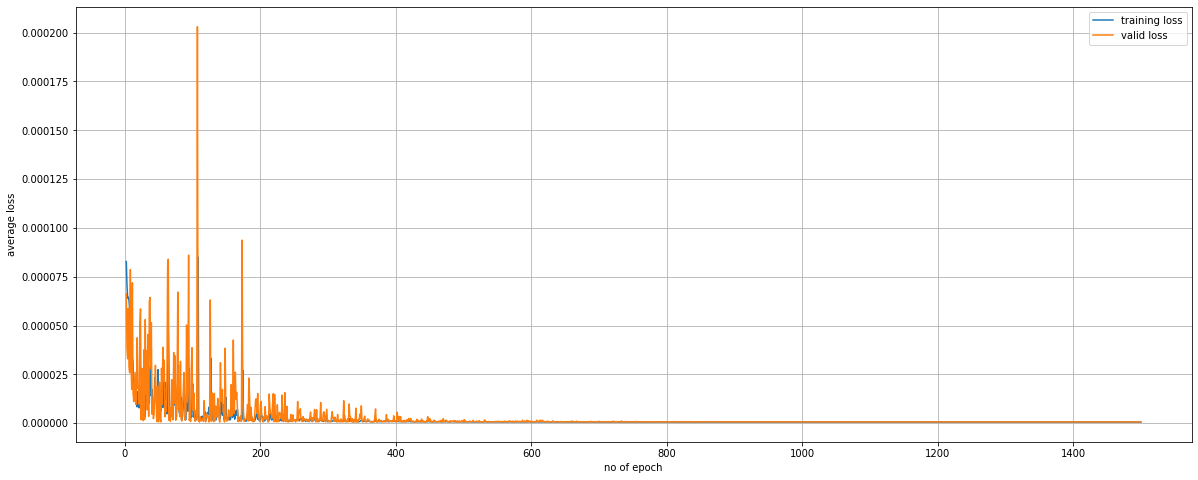

In [38]:
cluster_number=cluster_no

bob_training3 = []
bob_training_label3=[]
for x in range(len(kmeans.labels_)):
    if kmeans.labels_[x]==cluster_number:
        bob_training3.append(dataset_deep[x])
        bob_training_label3.append(dataset_deep_label[x])
        
        
bob_validation3 = []
bob_validation_label3=[]
for x in range(len(a)):
    if a[x]==cluster_number:
        bob_validation3.append(dataset_deep2[x])
        bob_validation_label3.append(dataset_deep_label2[x])
            
        






training_no=int(round(1*len(bob_training3),0))
training_len = training_no
validation_no = len(bob_validation3)
validation_len = validation_no
print(training_len)
print(validation_len)



train_dataset3 = TensorDataset(torch.tensor(bob_training3[:],dtype=torch.float32),
                              torch.tensor(bob_training_label3[:],dtype=torch.float32))

valid_dataset3 = TensorDataset(torch.tensor(bob_validation3[:],dtype=torch.float32),
                               torch.tensor(bob_validation_label3[:],dtype=torch.float32))



Embedding_dim=6
enc_Hidden_dim=52
dec_Hidden_dim=52 
Mydropout=0.5

attn = Attention(enc_Hidden_dim,dec_Hidden_dim)
encoder = Encoder(Embedding_dim,enc_Hidden_dim,dec_Hidden_dim,Mydropout)
decoder = Decoder(Embedding_dim,enc_Hidden_dim,dec_Hidden_dim,Mydropout,attn)

model_3_3 = Final_predictor(encoder,decoder,device)


batch_size=75
train_3_3 = DataLoader(train_dataset3,batch_size = batch_size,shuffle=True)
valid_3_3 = DataLoader(valid_dataset3,batch_size = batch_size,shuffle=False)
loss = F.mse_loss

sub_model_training(1500,model_3_3,train_3_3,valid_3_3,loss,0.01,device)


loss_nn = nn.L1Loss(reduction='sum')

with torch.no_grad():
    total_loss=0
    model_3_3.eval()
    for x,z in valid_3_3:
        z=z.to(device)
        pred = model_3_3(x.to(device))
        losses = loss_nn(pred,z.view(-1,1))
        total_loss+=losses.item()
        
    print("Average test MAE loss is {:.10f}".format(total_loss/validation_len))
    Confidence = math.ceil((total_loss/validation_len*2)*10000.0)/10000

In [43]:
#################################################################################################################

torch.save(model_3_3,'attention_trained.pth')

#new_model = torch.load('attention_trained.pth')


In [45]:
new_model = torch.load('attention_trained.pth')

##################################################################################################################

# Backtesting to evaluate model's performance on Test data

In [48]:
#############current strategy########################
######only trade when predicted 60min max price is higher than current close
######close position only when target price met or close at the end of 60 mins
######leverage is decided to be 100 if predicted min price is higher than current
###### or leverage is reduced to be the minimium of 1/(1-pred_min/current close) or 100
print(Confidence)
num_trades=0
profits=0
capital=10000
capital_checker=10000
capital_checker2=10000
cap_his=[]
cap_his2=[]
pro=[]
capital_leverage1 = 200*10000
capital_leverage2 = 1*10000
max_pred=[]
max_real=[]
entry_price=[]
future_close=[]
min_pred=[]
confidence_margin=Confidence
#confidence_margin=0
spread=0.00008

training_features1=['open','close','PLUS_DM','ADD','MULT','ROC']
training_features2=['open','close','PLUS_DM','ADD','MULT','CDLCONCEALBABYSWALL']

for x in range(10,len(df_holdout['rsi'])):

    
    if df_holdout['rsi'][x] <=30:
        data_feature,close,max_,min_ = myfeature_test(training_features1,x,9,0,4)
        #data_feature_min,__,__,__ = myfeature_test(training_features_min,x,9,0,4)
        data_convent,__,__,__ = myfeatureConventional_test(training_features2,x,9,0,4)
#         print(data_convent)
#         break
    
        if kmeans.predict(np.array(data_convent).reshape(1,-1)) ==cluster_number:

            data_max = torch.tensor(data_feature,dtype=torch.float32).unsqueeze(0)
            #data_min = torch.tensor(data_feature_min,dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                model_3_3.eval()
                preds = model_3_3(data_max.to(device))
                #preds_min = model_3_3_min(data_min.to(device))
                max_pred.append(preds.item())
                entry_price.append(data_feature[-1][1])
                max_real.append(max_)
                future_close.append(close)
                #min_pred.append(preds_min.item())
                #if preds_min >=data_feature[-1][1]:
                if preds >= (data_feature[-1][1]+confidence_margin):
                    capital_leverage = 200*capital
                #if preds_min < data_feature[-1][1]:
                if preds < (data_feature[-1][1]+confidence_margin):
                    #capital_leverage = min(1/(1-preds_min.item()/data_feature[-1][1]),30)*capital
                    capital_leverage = capital
                print("-------------------")
                print("max price prediction: ",preds.item())
                print("max price: ",max_)
                #print("min price prediction: ",preds_min.item())
                #print("min price: ",min_)
                print("close price or buy price: ",data_feature[-1][1])
                print("prediction difference max: ",preds.item()-max_)
                #print("prediction difference min: ",preds_min.item()-min_)
                print("----------------")
                if preds.item()>data_feature[-1][1]:
                    num_trades += 1
                    if preds.item()<=max_:
                        profits += capital_leverage*(preds.item()-data_feature[-1][1]-spread)
                        capital_checker += capital_leverage*(preds.item()-data_feature[-1][1]-spread)
                        pro.append(capital_leverage*(preds.item()-data_feature[-1][1]-spread))
                        capital_checker2 += capital_leverage*(min_ - data_feature[-1][1]-spread)
                    if preds.item()>max_:
                        profits += capital_leverage*(close - data_feature[-1][1]-spread)
                        capital_checker += capital_leverage*(close - data_feature[-1][1]-spread)
                        pro.append(capital_leverage*(close - data_feature[-1][1]-spread))
                        capital_checker2 += capital_leverage*(min_ - data_feature[-1][1]-spread)
                    print("profits: ",profits)
                    print("Return on Capital: {:.3%}".format(profits/capital))
                    print("accumulated number of trades: ",num_trades)
                    #capital_checker+=profits
                    cap_his.append(capital_checker)
                    cap_his2.append(capital_checker2)
                elif preds.item()<data_feature[-1][1]:
                    profits += 0
                    pro.append(0)
                    
    capital_checker2 = capital_checker

        

0.0013


C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

-------------------
max price prediction:  0.7447832822799683
max price:  0.74432
close price or buy price:  0.74384
prediction difference max:  0.0004632822799682801
----------------
profits:  -7.800000000000339
Return on Capital: -0.078%
accumulated number of trades:  1
-------------------
max price prediction:  0.744123637676239
max price:  0.74358
close price or buy price:  0.74358
prediction difference max:  0.000543637676238995
----------------
profits:  -9.899999999999974
Return on Capital: -0.099%
accumulated number of trades:  2
-------------------
max price prediction:  0.7439641952514648
max price:  0.7436
close price or buy price:  0.7431399999999999
prediction difference max:  0.000364195251464805
----------------
profits:  -7.899999999999394
Return on Capital: -0.079%
accumulated number of trades:  3
-------------------
max price prediction:  0.7547143697738647
max price:  0.75398
close price or buy price:  0.7537
prediction difference max:  0.0007343697738647625
--------

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

-------------------
max price prediction:  0.7541651129722595
max price:  0.75459
close price or buy price:  0.75354
prediction difference max:  -0.0004248870277404615
----------------
profits:  11.572847366333201
Return on Capital: 0.116%
accumulated number of trades:  8
-------------------
max price prediction:  0.7522156238555908
max price:  0.75166
close price or buy price:  0.75168
prediction difference max:  0.0005556238555908255
----------------
profits:  3.4728473663331165
Return on Capital: 0.035%
accumulated number of trades:  9
-------------------
max price prediction:  0.7522605061531067
max price:  0.75144
close price or buy price:  0.75138
prediction difference max:  0.0008205061531066926
----------------
profits:  3.272847366332606
Return on Capital: 0.033%
accumulated number of trades:  10
-------------------
max price prediction:  0.7517287731170654
max price:  0.75165
close price or buy price:  0.751
prediction difference max:  7.877311706538936e-05
----------------
p

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

-------------------
max price prediction:  0.759962260723114
max price:  0.75948
close price or buy price:  0.75931
prediction difference max:  0.0004822607231139697
----------------
profits:  -0.5768373489383976
Return on Capital: -0.006%
accumulated number of trades:  16
-------------------
max price prediction:  0.759699821472168
max price:  0.75918
close price or buy price:  0.7588600000000001
prediction difference max:  0.0005198214721680028
----------------
profits:  1.423162651059962
Return on Capital: 0.014%
accumulated number of trades:  17
-------------------
max price prediction:  0.7595731019973755
max price:  0.75948
close price or buy price:  0.7587
prediction difference max:  9.310199737544433e-05
----------------
profits:  8.023162651059591
Return on Capital: 0.080%
accumulated number of trades:  18
-------------------
max price prediction:  0.7590775489807129
max price:  0.76018
close price or buy price:  0.75844
prediction difference max:  -0.0011024510192870762
-----

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

-------------------
max price prediction:  0.7540374994277954
max price:  0.753
close price or buy price:  0.75293
prediction difference max:  0.0010374994277954075
----------------
profits:  -3.3511405944833044
Return on Capital: -0.034%
accumulated number of trades:  33
-------------------
max price prediction:  0.753333330154419
max price:  0.75262
close price or buy price:  0.75255
prediction difference max:  0.0007133301544189896
----------------
profits:  -64.8511405944835
Return on Capital: -0.649%
accumulated number of trades:  34
-------------------
max price prediction:  0.7521899342536926
max price:  0.7510600000000001
close price or buy price:  0.75102
prediction difference max:  0.001129934253692566
----------------
profits:  -92.05114059448326
Return on Capital: -0.921%
accumulated number of trades:  35
-------------------
max price prediction:  0.7511816024780273
max price:  0.7498
close price or buy price:  0.74976
prediction difference max:  0.0013816024780273217
-----

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

-------------------
max price prediction:  0.7594813108444214
max price:  0.75868
close price or buy price:  0.7586
prediction difference max:  0.0008013108444213657
----------------
profits:  4492.260538292061
Return on Capital: 44.923%
accumulated number of trades:  41
-------------------
max price prediction:  0.7588653564453125
max price:  0.75893
close price or buy price:  0.75798
prediction difference max:  -6.46435546874935e-05
----------------
profits:  4500.314102745187
Return on Capital: 45.003%
accumulated number of trades:  42
-------------------
max price prediction:  0.7587892413139343
max price:  0.75944
close price or buy price:  0.7581399999999999
prediction difference max:  -0.0006507586860656778
----------------
profits:  4506.006515884531
Return on Capital: 45.060%
accumulated number of trades:  43
-------------------
max price prediction:  0.7586240172386169
max price:  0.75993
close price or buy price:  0.75802
prediction difference max:  -0.001305982761383051
---

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

-------------------
max price prediction:  0.7686635851860046
max price:  0.7684
close price or buy price:  0.76822
prediction difference max:  0.00026358518600466674
----------------
profits:  4425.246688270701
Return on Capital: 44.252%
accumulated number of trades:  49
-------------------
max price prediction:  0.7688181400299072
max price:  0.76827
close price or buy price:  0.7680600000000001
prediction difference max:  0.0005481400299072181
----------------
profits:  4399.8466882707
Return on Capital: 43.998%
accumulated number of trades:  50
-------------------
max price prediction:  0.7680936455726624
max price:  0.76718
close price or buy price:  0.7671
prediction difference max:  0.0009136455726623804
----------------
profits:  4383.4466882707
Return on Capital: 43.834%
accumulated number of trades:  51
-------------------
max price prediction:  0.7668113708496094
max price:  0.76612
close price or buy price:  0.7655
prediction difference max:  0.0006913708496093518
---------

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

max price prediction:  0.7743502855300903
max price:  0.7753
close price or buy price:  0.77344
prediction difference max:  -0.0009497144699096571
----------------
profits:  7706.213402557684
Return on Capital: 77.062%
accumulated number of trades:  57
-------------------
max price prediction:  0.7774720191955566
max price:  0.77733
close price or buy price:  0.77659
prediction difference max:  0.0001420191955566752
----------------
profits:  7694.313402557685
Return on Capital: 76.943%
accumulated number of trades:  58
-------------------
max price prediction:  0.7769081592559814
max price:  0.77608
close price or buy price:  0.77605
prediction difference max:  0.0008281592559814532
----------------
profits:  7675.0134025576845
Return on Capital: 76.750%
accumulated number of trades:  59
-------------------
max price prediction:  0.7761465907096863
max price:  0.77586
close price or buy price:  0.77531
prediction difference max:  0.0002865907096862852
----------------
profits:  7657.8

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

-------------------
max price prediction:  0.774372935295105
max price:  0.77468
close price or buy price:  0.77368
prediction difference max:  -0.0003070647048950548
----------------
profits:  7631.942755508733
Return on Capital: 76.319%
accumulated number of trades:  66
-------------------
max price prediction:  0.7747842073440552
max price:  0.7751899999999999
close price or buy price:  0.77388
prediction difference max:  -0.0004057926559447589
----------------
profits:  7640.184828949285
Return on Capital: 76.402%
accumulated number of trades:  67
-------------------
max price prediction:  0.7744332551956177
max price:  0.77536
close price or buy price:  0.77371
prediction difference max:  -0.0009267448043823734
----------------
profits:  7646.617380905462
Return on Capital: 76.466%
accumulated number of trades:  68
-------------------
max price prediction:  0.7744147777557373
max price:  0.77536
close price or buy price:  0.77394
prediction difference max:  -0.0009452222442627445


C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

-------------------
max price prediction:  0.7727991342544556
max price:  0.7720600000000001
close price or buy price:  0.77193
prediction difference max:  0.0007391342544554869
----------------
profits:  7596.4651584628355
Return on Capital: 75.965%
accumulated number of trades:  75
-------------------
max price prediction:  0.7721384167671204
max price:  0.77156
close price or buy price:  0.7713
prediction difference max:  0.0005784167671203377
----------------
profits:  7580.865158462835
Return on Capital: 75.809%
accumulated number of trades:  76
-------------------
max price prediction:  0.7720584869384766
max price:  0.7714300000000001
close price or buy price:  0.77146
prediction difference max:  0.0006284869384765024
----------------
profits:  7567.665158462835
Return on Capital: 75.677%
accumulated number of trades:  77
-------------------
max price prediction:  0.771797776222229
max price:  0.77128
close price or buy price:  0.771
prediction difference max:  0.000517776222229

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

-------------------
max price prediction:  0.7707359790802002
max price:  0.7700199999999999
close price or buy price:  0.76964
prediction difference max:  0.0007159790802002686
----------------
profits:  7585.813370132758
Return on Capital: 75.858%
accumulated number of trades:  84
-------------------
max price prediction:  0.7686524987220764
max price:  0.76899
close price or buy price:  0.7676
prediction difference max:  -0.00033750127792353535
----------------
profits:  7595.538357353523
Return on Capital: 75.955%
accumulated number of trades:  85
-------------------
max price prediction:  0.7680413722991943
max price:  0.76937
close price or buy price:  0.7669
prediction difference max:  -0.0013286277008056624
----------------
profits:  7606.152080345466
Return on Capital: 76.062%
accumulated number of trades:  86
-------------------
max price prediction:  0.7743074893951416
max price:  0.7744800000000001
close price or buy price:  0.77391
prediction difference max:  -0.0001725106

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

-------------------
max price prediction:  0.7743545174598694
max price:  0.77462
close price or buy price:  0.77354
prediction difference max:  -0.00026548254013059047
----------------
profits:  7629.139112091379
Return on Capital: 76.291%
accumulated number of trades:  93
-------------------
max price prediction:  0.774087131023407
max price:  0.77462
close price or buy price:  0.77358
prediction difference max:  -0.0005328689765929928
----------------
profits:  7633.410422325448
Return on Capital: 76.334%
accumulated number of trades:  94
-------------------
max price prediction:  0.772932767868042
max price:  0.77251
close price or buy price:  0.77205
prediction difference max:  0.0004227678680419622
----------------
profits:  7620.810422325448
Return on Capital: 76.208%
accumulated number of trades:  95
-------------------
max price prediction:  0.7721381783485413
max price:  0.77251
close price or buy price:  0.771
prediction difference max:  -0.0003718216514587702
--------------

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

-------------------
max price prediction:  0.7707831263542175
max price:  0.77246
close price or buy price:  0.7699
prediction difference max:  -0.0016768736457825062
----------------
profits:  7656.910562324839
Return on Capital: 76.569%
accumulated number of trades:  101
-------------------
max price prediction:  0.7693235874176025
max price:  0.76952
close price or buy price:  0.7683399999999999
prediction difference max:  -0.00019641258239744275
----------------
profits:  7665.946436500865
Return on Capital: 76.659%
accumulated number of trades:  102
-------------------
max price prediction:  0.7693197727203369
max price:  0.76959
close price or buy price:  0.7685
prediction difference max:  -0.00027022727966308224
----------------
profits:  7673.344163704235
Return on Capital: 76.733%
accumulated number of trades:  103
-------------------
max price prediction:  0.7740959525108337
max price:  0.7738
close price or buy price:  0.77344
prediction difference max:  0.000295952510833696

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

-------------------
max price prediction:  0.7719698548316956
max price:  0.77158
close price or buy price:  0.7713
prediction difference max:  0.00038985483169551305
----------------
profits:  7662.617206001599
Return on Capital: 76.626%
accumulated number of trades:  110
-------------------
max price prediction:  0.7714348435401917
max price:  0.77158
close price or buy price:  0.77105
prediction difference max:  -0.0001451564598083932
----------------
profits:  7665.665641403515
Return on Capital: 76.657%
accumulated number of trades:  111
-------------------
max price prediction:  0.7716487646102905
max price:  0.77158
close price or buy price:  0.7712
prediction difference max:  6.876461029048375e-05
----------------
profits:  7661.465641403515
Return on Capital: 76.615%
accumulated number of trades:  112
-------------------
max price prediction:  0.7717528343200684
max price:  0.77148
close price or buy price:  0.77093
prediction difference max:  0.00027283432006830477
----------

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

-------------------
max price prediction:  0.7694652676582336
max price:  0.7689
close price or buy price:  0.76884
prediction difference max:  0.0005652676582336147
----------------
profits:  10273.825836372711
Return on Capital: 102.738%
accumulated number of trades:  119
-------------------
max price prediction:  0.7689882516860962
max price:  0.76883
close price or buy price:  0.76842
prediction difference max:  0.000158251686096178
----------------
profits:  10272.425836372711
Return on Capital: 102.724%
accumulated number of trades:  120
-------------------
max price prediction:  0.7689820528030396
max price:  0.76893
close price or buy price:  0.76852
prediction difference max:  5.20528030395484e-05
----------------
profits:  10273.62583637271
Return on Capital: 102.736%
accumulated number of trades:  121
-------------------
max price prediction:  0.7685062289237976
max price:  0.76893
close price or buy price:  0.76808
prediction difference max:  -0.00042377107620239496
-------

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

-------------------
max price prediction:  0.7721605896949768
max price:  0.77132
close price or buy price:  0.77093
prediction difference max:  0.000840589694976801
----------------
profits:  10286.938540840485
Return on Capital: 102.869%
accumulated number of trades:  127
-------------------
max price prediction:  0.7714806795120239
max price:  0.77132
close price or buy price:  0.7709
prediction difference max:  0.00016067951202392017
----------------
profits:  10271.138540840484
Return on Capital: 102.711%
accumulated number of trades:  128
-------------------
max price prediction:  0.7712758779525757
max price:  0.77058
close price or buy price:  0.7703899999999999
prediction difference max:  0.0006958779525756409
----------------
profits:  10260.838540840485
Return on Capital: 102.608%
accumulated number of trades:  129
-------------------
max price prediction:  0.771206259727478
max price:  0.77058
close price or buy price:  0.7704
prediction difference max:  0.00062625972747798

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

-------------------
max price prediction:  0.7693251967430115
max price:  0.76932
close price or buy price:  0.76876
prediction difference max:  5.1967430114707724e-06
----------------
profits:  10154.338540840485
Return on Capital: 101.543%
accumulated number of trades:  136
-------------------
max price prediction:  0.7694028615951538
max price:  0.7688
close price or buy price:  0.76812
prediction difference max:  0.0006028615951537697
----------------
profits:  10138.238540840484
Return on Capital: 101.382%
accumulated number of trades:  137
-------------------
max price prediction:  0.7692610025405884
max price:  0.7688
close price or buy price:  0.76876
prediction difference max:  0.00046100254058834
----------------
profits:  10125.138540840484
Return on Capital: 101.251%
accumulated number of trades:  138
-------------------
max price prediction:  0.767350435256958
max price:  0.76852
close price or buy price:  0.76558
prediction difference max:  -0.0011695647430419731
--------

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

prediction difference max:  -0.0013537812995910725
----------------
profits:  16100.632312965665
Return on Capital: 161.006%
accumulated number of trades:  144
-------------------
max price prediction:  0.7612090110778809
max price:  0.76283
close price or buy price:  0.76048
prediction difference max:  -0.0016209889221191487
----------------
profits:  16107.122423744473
Return on Capital: 161.071%
accumulated number of trades:  145
-------------------
max price prediction:  0.7650970816612244
max price:  0.76471
close price or buy price:  0.76436
prediction difference max:  0.0003870816612243644
----------------
profits:  16108.522423744473
Return on Capital: 161.085%
accumulated number of trades:  146
-------------------
max price prediction:  0.7647720575332642
max price:  0.76472
close price or buy price:  0.76386
prediction difference max:  5.2057533264204814e-05
----------------
profits:  16116.022423744473
Return on Capital: 161.160%
accumulated number of trades:  147
----------

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

-------------------
max price prediction:  0.7601000070571899
max price:  0.76064
close price or buy price:  0.75926
prediction difference max:  -0.0005399929428100414
----------------
profits:  16138.532555389675
Return on Capital: 161.385%
accumulated number of trades:  153
-------------------
max price prediction:  0.7579385042190552
max price:  0.75903
close price or buy price:  0.75688
prediction difference max:  -0.0010914957809448067
----------------
profits:  16148.317597580226
Return on Capital: 161.483%
accumulated number of trades:  154
-------------------
max price prediction:  0.7615319490432739
max price:  0.7623800000000001
close price or buy price:  0.76076
prediction difference max:  -0.0008480509567261318
----------------
profits:  16155.237088012966
Return on Capital: 161.552%
accumulated number of trades:  155
-------------------
max price prediction:  0.7735078930854797
max price:  0.77282
close price or buy price:  0.77274
prediction difference max:  0.00068789308

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

-------------------
max price prediction:  0.7753234505653381
max price:  0.77551
close price or buy price:  0.77404
prediction difference max:  -0.00018654943466189788
----------------
profits:  16189.534709930693
Return on Capital: 161.895%
accumulated number of trades:  169
-------------------
max price prediction:  0.7893028259277344
max price:  0.7882399999999999
close price or buy price:  0.7873
prediction difference max:  0.0010628259277344343
----------------
profits:  14969.534709930631
Return on Capital: 149.695%
accumulated number of trades:  170
-------------------

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py


max price prediction:  0.7884701490402222
max price:  0.7882399999999999
close price or buy price:  0.78706
prediction difference max:  0.00023014904022222726
----------------
profits:  15689.534709930624
Return on Capital: 156.895%
accumulated number of trades:  171
-------------------
max price prediction:  0.7885830402374268
max price:  0.78787
close price or buy price:  0.78651
prediction difference max:  0.0007130402374267986
----------------
profits:  16889.53470993043
Return on Capital: 168.895%
accumulated number of trades:  172
-------------------
max price prediction:  0.7887423038482666
max price:  0.7880699999999999
close price or buy price:  0.78695
prediction difference max:  0.0006723038482666643
----------------
profits:  18749.53470993034
Return on Capital: 187.495%
accumulated number of trades:  173
-------------------
max price prediction:  0.7881262302398682
max price:  0.7880699999999999
close price or buy price:  0.78677
prediction difference max:  5.623023986822

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

-------------------
max price prediction:  0.7782071232795715
max price:  0.7788
close price or buy price:  0.77672
prediction difference max:  -0.0005928767204285146
----------------
profits:  29070.573848533764
Return on Capital: 290.706%
accumulated number of trades:  179
-------------------
max price prediction:  0.7784278392791748
max price:  0.7772600000000001
close price or buy price:  0.77705
prediction difference max:  0.0011678392791747427
----------------
profits:  23130.573848533866
Return on Capital: 231.306%
accumulated number of trades:  180
-------------------
max price prediction:  0.7773383259773254
max price:  0.77641
close price or buy price:  0.7760600000000001
prediction difference max:  0.0009283259773253949
----------------
profits:  23129.973848533864
Return on Capital: 231.300%
accumulated number of trades:  181
-------------------
max price prediction:  0.7759116888046265
max price:  0.7774800000000001
close price or buy price:  0.77352
prediction difference 

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

In [41]:
len(pro)

184

In [91]:
ddd = {'pred_max':max_pred,'real_max':max_real,'entry_price':entry_price,'future close':future_close,'profit':pro}

df222 = pd.DataFrame(data=ddd)
df222.to_csv('mydata week15v4.csv',index=False)

In [42]:
############Profit by each trade###########
sorted(pro)

[-5939.999999999896,
 -1220.000000000061,
 -120.00000000018206,
 -61.5000000000002,
 -49.700000000000614,
 -33.20000000000021,
 -30.400000000000738,
 -29.599999999999937,
 -27.199999999999758,
 -25.400000000001288,
 -19.300000000000182,
 -17.80000000000035,
 -17.20000000000086,
 -16.40000000000006,
 -16.100000000000314,
 -15.80000000000057,
 -15.700000000001024,
 -15.60000000000037,
 -14.399999999999169,
 -13.99999999999988,
 -13.79999999999968,
 -13.300000000000844,
 -13.20000000000019,
 -13.099999999999534,
 -12.79999999999979,
 -12.6000000000007,
 -12.500000000000044,
 -12.500000000000044,
 -12.099999999999644,
 -11.899999999999444,
 -11.40000000000061,
 -10.899999999999554,
 -10.80000000000001,
 -10.59999999999981,
 -10.299999999998954,
 -9.099999999999975,
 -8.99999999999932,
 -8.80000000000023,
 -8.39999999999983,
 -8.100000000000085,
 -7.800000000000339,
 -7.600000000000139,
 -7.199999999999739,
 -6.999999999999539,
 -6.899999999998884,
 -6.599999999999139,
 -6.400000000000049,


In [44]:
len(pro)

184

In [50]:
##########total profit##############
profits

31562.56887702954

In [46]:
#just tracks movement of our 10k capital after each trade
cap_his

[9992.199999999999,
 9990.099999999999,
 9992.099999999999,
 9989.699999999999,
 9993.3,
 10000.69943962097,
 10006.484709930419,
 10013.108263015745,
 10005.008263015745,
 10004.808263015744,
 10010.108263015743,
 10015.427252769467,
 10023.33110733032,
 10022.53110733032,
 10010.43110733032,
 10001.33110733032,
 10003.331107330318,
 10009.931107330318,
 10015.898795700068,
 10020.655860900873,
 10028.840713691705,
 10036.091267395013,
 10036.391267395014,
 10456.39126739504,
 10457.39126739504,
 10453.79126739504,
 10452.591267395039,
 10438.19126739504,
 10445.373308563252,
 10454.799661064168,
 10460.894596481343,
 10466.297393608113,
 10416.597393608112,
 10355.097393608112,
 10327.897393608113,
 10315.097393608114,
 13212.141346550154,
 16951.095776176553,
 16961.09321117411,
 16969.758542633153,
 16968.758542633153,
 16976.56534385691,
 16982.732806015112,
 16990.344051170447,
 16990.144051170446,
 16985.744051170448,
 16967.94405117045,
 16937.544051170447,
 16904.344051170447,

In [52]:
######Lowest capital level hits based on executed trades
min(cap_his)

9989.699999999999

In [48]:
num_trades

184

In [49]:
#just tracks movement of our capital in regards to low price hit even without trade
cap_his2

[9991.1,
 9979.199999999999,
 9981.5,
 9987.499999999998,
 9984.3,
 9991.3,
 9998.59943962097,
 10005.08470993042,
 10003.108263015745,
 9998.008263015745,
 10001.608263015743,
 10007.708263015744,
 10014.927252769467,
 10021.03110733032,
 10009.93110733032,
 9999.531107330318,
 9994.931107330318,
 9998.531107330316,
 10007.731107330317,
 10015.098795700069,
 10016.355860900872,
 10023.440713691705,
 10033.091267395013,
 9696.391267395167,
 10450.69126739504,
 10451.89126739504,
 10448.89126739504,
 10424.291267395038,
 10426.091267395039,
 10439.273308563252,
 10448.899661064168,
 10448.094596481344,
 10415.797393608113,
 10352.29739360811,
 10306.097393608112,
 10291.497393608113,
 6475.097393608208,
 12572.141346550117,
 16946.295776176554,
 16959.69321117411,
 16960.65854263315,
 16965.858542633152,
 16972.46534385691,
 16982.13280601511,
 16986.144051170446,
 16978.944051170445,
 16966.744051170448,
 16936.94405117045,
 16903.144051170446,
 16865.544051170447,
 16849.744051170444,

In [53]:
#Minimium level of initial $10,000 capital based on low price hits (not necessary)
min(cap_his2)

6475.097393608208

In [51]:
sum(pro)

24709.955430793736

In [20]:
import pickle
with open("k_means.pkl","rb") as f:
    L_Kmeans = pickle.load(f)
    
    
# L_Kmeans.predict(testing)
# Counter(L_Kmeans.labels_)

In [27]:
new_model = torch.load('attention_trained.pth')

In [30]:
#############current strategy########################
######only trade when predicted 60min max price is higher than current close
######close position only when target price met or close at the end of 60 mins
######leverage is decided to be 100 if predicted min price is higher than current
###### or leverage is reduced to be the minimium of 1/(1-pred_min/current close) or 100
Confidence = 0.0013
cluster_number=1


print(Confidence)
num_trades=0
profits=0
capital=10000
capital_checker=10000
capital_checker2=10000
cap_his=[]
cap_his2=[]
pro=[]
capital_leverage1 = 200*10000
capital_leverage2 = 1*10000
max_pred=[]
max_real=[]
entry_price=[]
future_close=[]
min_pred=[]
confidence_margin=Confidence
#confidence_margin=0
spread=0.00008

training_features1=['open','close','PLUS_DM','ADD','MULT','ROC']
training_features2=['open','close','PLUS_DM','ADD','MULT','CDLCONCEALBABYSWALL']

for x in range(10,len(df_holdout['rsi'])):

    
    if df_holdout['rsi'][x] <=30:
        data_feature,close,max_,min_ = myfeature_test(training_features1,x,9,0,4)
        #data_feature_min,__,__,__ = myfeature_test(training_features_min,x,9,0,4)
        data_convent,__,__,__ = myfeatureConventional_test(training_features2,x,9,0,4)
#         print(data_convent)
#         break
    
        if L_Kmeans.predict(np.array(data_convent).reshape(1,-1)) ==cluster_number:

            data_max = torch.tensor(data_feature,dtype=torch.float32).unsqueeze(0)
            #data_min = torch.tensor(data_feature_min,dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                new_model.eval()
                preds = new_model(data_max.to(device))
                #preds_min = model_3_3_min(data_min.to(device))
                max_pred.append(preds.item())
                entry_price.append(data_feature[-1][1])
                max_real.append(max_)
                future_close.append(close)
                #min_pred.append(preds_min.item())
                #if preds_min >=data_feature[-1][1]:
                if preds >= (data_feature[-1][1]+confidence_margin):
                    capital_leverage = 200*capital
                #if preds_min < data_feature[-1][1]:
                if preds < (data_feature[-1][1]+confidence_margin):
                    #capital_leverage = min(1/(1-preds_min.item()/data_feature[-1][1]),30)*capital
                    capital_leverage = capital
                print("-------------------")
                print("max price prediction: ",preds.item())
                print("max price: ",max_)
                #print("min price prediction: ",preds_min.item())
                #print("min price: ",min_)
                print("close price or buy price: ",data_feature[-1][1])
                print("prediction difference max: ",preds.item()-max_)
                #print("prediction difference min: ",preds_min.item()-min_)
                print("----------------")
                if preds.item()>data_feature[-1][1]:
                    num_trades += 1
                    if preds.item()<=max_:
                        profits += capital_leverage*(preds.item()-data_feature[-1][1]-spread)
                        capital_checker += capital_leverage*(preds.item()-data_feature[-1][1]-spread)
                        pro.append(capital_leverage*(preds.item()-data_feature[-1][1]-spread))
                        capital_checker2 += capital_leverage*(min_ - data_feature[-1][1]-spread)
                    if preds.item()>max_:
                        profits += capital_leverage*(close - data_feature[-1][1]-spread)
                        capital_checker += capital_leverage*(close - data_feature[-1][1]-spread)
                        pro.append(capital_leverage*(close - data_feature[-1][1]-spread))
                        capital_checker2 += capital_leverage*(min_ - data_feature[-1][1]-spread)
                    print("profits: ",profits)
                    print("Return on Capital: {:.3%}".format(profits/capital))
                    print("accumulated number of trades: ",num_trades)
                    #capital_checker+=profits
                    cap_his.append(capital_checker)
                    cap_his2.append(capital_checker2)
                elif preds.item()<data_feature[-1][1]:
                    profits += 0
                    pro.append(0)
                    
    capital_checker2 = capital_checker


0.0013


C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

-------------------
max price prediction:  0.7447832822799683
max price:  0.74432
close price or buy price:  0.74384
prediction difference max:  0.0004632822799682801
----------------
profits:  -7.800000000000339
Return on Capital: -0.078%
accumulated number of trades:  1
-------------------
max price prediction:  0.744123637676239
max price:  0.74358
close price or buy price:  0.74358
prediction difference max:  0.000543637676238995
----------------
profits:  -9.899999999999974
Return on Capital: -0.099%
accumulated number of trades:  2
-------------------
max price prediction:  0.7439641952514648
max price:  0.7436
close price or buy price:  0.7431399999999999
prediction difference max:  0.000364195251464805
----------------
profits:  -7.899999999999394
Return on Capital: -0.079%
accumulated number of trades:  3
-------------------
max price prediction:  0.7547143697738647
max price:  0.75398
close price or buy price:  0.7537
prediction difference max:  0.0007343697738647625
--------

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

-------------------
max price prediction:  0.7541651129722595
max price:  0.75459
close price or buy price:  0.75354
prediction difference max:  -0.0004248870277404615
----------------
profits:  11.572847366333201
Return on Capital: 0.116%
accumulated number of trades:  8
-------------------
max price prediction:  0.7522156238555908
max price:  0.75166
close price or buy price:  0.75168
prediction difference max:  0.0005556238555908255
----------------
profits:  3.4728473663331165
Return on Capital: 0.035%
accumulated number of trades:  9
-------------------
max price prediction:  0.7522605061531067
max price:  0.75144
close price or buy price:  0.75138
prediction difference max:  0.0008205061531066926
----------------
profits:  3.272847366332606
Return on Capital: 0.033%
accumulated number of trades:  10
-------------------
max price prediction:  0.7517287731170654
max price:  0.75165
close price or buy price:  0.751
prediction difference max:  7.877311706538936e-05
----------------
p

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py


max price prediction:  0.759962260723114
max price:  0.75948
close price or buy price:  0.75931
prediction difference max:  0.0004822607231139697
----------------
profits:  -0.5768373489383976
Return on Capital: -0.006%
accumulated number of trades:  16
-------------------
max price prediction:  0.759699821472168
max price:  0.75918
close price or buy price:  0.7588600000000001
prediction difference max:  0.0005198214721680028
----------------
profits:  1.423162651059962
Return on Capital: 0.014%
accumulated number of trades:  17
-------------------
max price prediction:  0.7595731019973755
max price:  0.75948
close price or buy price:  0.7587
prediction difference max:  9.310199737544433e-05
----------------
profits:  8.023162651059591
Return on Capital: 0.080%
accumulated number of trades:  18
-------------------
max price prediction:  0.7590775489807129
max price:  0.76018
close price or buy price:  0.75844
prediction difference max:  -0.0011024510192870762
----------------
profits

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

max price prediction:  0.7580946683883667
max price:  0.75744
close price or buy price:  0.75689
prediction difference max:  0.000654668388366697
----------------
profits:  34.13297576904039
Return on Capital: 0.341%
accumulated number of trades:  24
-------------------
max price prediction:  0.7570343017578125
max price:  0.75662
close price or buy price:  0.7562
prediction difference max:  0.00041430175781254075
----------------
profits:  35.13297576904108
Return on Capital: 0.351%
accumulated number of trades:  25
-------------------
max price prediction:  0.7568288445472717
max price:  0.75662
close price or buy price:  0.75618
prediction difference max:  0.00020884454727176927
----------------
profits:  31.532975769041613
Return on Capital: 0.315%
accumulated number of trades:  26
-------------------
max price prediction:  0.7566984295845032
max price:  0.75658
close price or buy price:  0.7560600000000001
prediction difference max:  0.00011842958450314356
----------------
profits

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

-------------------
max price prediction:  0.7540374994277954
max price:  0.753
close price or buy price:  0.75293
prediction difference max:  0.0010374994277954075
----------------
profits:  -3.3511405944833044
Return on Capital: -0.034%
accumulated number of trades:  33
-------------------
max price prediction:  0.753333330154419
max price:  0.75262
close price or buy price:  0.75255
prediction difference max:  0.0007133301544189896
----------------
profits:  -64.8511405944835
Return on Capital: -0.649%
accumulated number of trades:  34
-------------------
max price prediction:  0.7521899342536926
max price:  0.7510600000000001
close price or buy price:  0.75102
prediction difference max:  0.001129934253692566
----------------
profits:  -92.05114059448326
Return on Capital: -0.921%
accumulated number of trades:  35
-------------------
max price prediction:  0.7511816024780273
max price:  0.7498
close price or buy price:  0.74976
prediction difference max:  0.0013816024780273217
-----

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

-------------------
max price prediction:  0.7588653564453125
max price:  0.75893
close price or buy price:  0.75798
prediction difference max:  -6.46435546874935e-05
----------------
profits:  4500.314102745187
Return on Capital: 45.003%
accumulated number of trades:  42
-------------------
max price prediction:  0.7587892413139343
max price:  0.75944
close price or buy price:  0.7581399999999999
prediction difference max:  -0.0006507586860656778
----------------
profits:  4506.006515884531
Return on Capital: 45.060%
accumulated number of trades:  43
-------------------
max price prediction:  0.7586240172386169
max price:  0.75993
close price or buy price:  0.75802
prediction difference max:  -0.001305982761383051
----------------
profits:  4511.2466882707
Return on Capital: 45.112%
accumulated number of trades:  44
-------------------
max price prediction:  0.7577442526817322
max price:  0.75738
close price or buy price:  0.75664
prediction difference max:  0.00036425268173212455
---

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

-------------------
max price prediction:  0.7688181400299072
max price:  0.76827
close price or buy price:  0.7680600000000001
prediction difference max:  0.0005481400299072181
----------------
profits:  4399.8466882707
Return on Capital: 43.998%
accumulated number of trades:  50
-------------------
max price prediction:  0.7680936455726624
max price:  0.76718
close price or buy price:  0.7671
prediction difference max:  0.0009136455726623804
----------------
profits:  4383.4466882707
Return on Capital: 43.834%
accumulated number of trades:  51
-------------------
max price prediction:  0.7668113708496094
max price:  0.76612
close price or buy price:  0.7655
prediction difference max:  0.0006913708496093518
----------------
profits:  5383.44668827075
Return on Capital: 53.834%
accumulated number of trades:  52
-------------------
max price prediction:  0.7662930488586426
max price:  0.76625
close price or buy price:  0.76498
prediction difference max:  4.304885864259145e-05
----------

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

-------------------
max price prediction:  0.7774720191955566
max price:  0.77733
close price or buy price:  0.77659
prediction difference max:  0.0001420191955566752
----------------
profits:  7694.313402557685
Return on Capital: 76.943%
accumulated number of trades:  58
-------------------
max price prediction:  0.7769081592559814
max price:  0.77608
close price or buy price:  0.77605
prediction difference max:  0.0008281592559814532
----------------
profits:  7675.0134025576845
Return on Capital: 76.750%
accumulated number of trades:  59
-------------------
max price prediction:  0.7761465907096863
max price:  0.77586
close price or buy price:  0.77531
prediction difference max:  0.0002865907096862852
----------------
profits:  7657.813402557684
Return on Capital: 76.578%
accumulated number of trades:  60
-------------------
max price prediction:  0.7762293815612793
max price:  0.7757
close price or buy price:  0.7754800000000001
prediction difference max:  0.0005293815612793518
---

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

-------------------
max price prediction:  0.774372935295105
max price:  0.77468
close price or buy price:  0.77368
prediction difference max:  -0.0003070647048950548
----------------
profits:  7631.942755508733
Return on Capital: 76.319%
accumulated number of trades:  66
-------------------
max price prediction:  0.7747842073440552
max price:  0.7751899999999999
close price or buy price:  0.77388
prediction difference max:  -0.0004057926559447589
----------------
profits:  7640.184828949285
Return on Capital: 76.402%
accumulated number of trades:  67
-------------------
max price prediction:  0.7744332551956177
max price:  0.77536
close price or buy price:  0.77371
prediction difference max:  -0.0009267448043823734
----------------
profits:  7646.617380905462
Return on Capital: 76.466%
accumulated number of trades:  68
-------------------
max price prediction:  0.7744147777557373
max price:  0.77536
close price or buy price:  0.77394
prediction difference max:  -0.0009452222442627445


C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

-------------------
max price prediction:  0.7728646397590637
max price:  0.77215
close price or buy price:  0.7718
prediction difference max:  0.0007146397590637177
----------------
profits:  7608.9651584628355
Return on Capital: 76.090%
accumulated number of trades:  74
-------------------
max price prediction:  0.7727991342544556
max price:  0.7720600000000001
close price or buy price:  0.77193
prediction difference max:  0.0007391342544554869
----------------
profits:  7596.4651584628355
Return on Capital: 75.965%
accumulated number of trades:  75
-------------------
max price prediction:  0.7721384167671204
max price:  0.77156
close price or buy price:  0.7713
prediction difference max:  0.0005784167671203377
----------------
profits:  7580.865158462835
Return on Capital: 75.809%
accumulated number of trades:  76
-------------------
max price prediction:  0.7720584869384766
max price:  0.7714300000000001
close price or buy price:  0.77146
prediction difference max:  0.000628486938

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

-------------------
max price prediction:  0.7709527611732483
max price:  0.77153
close price or buy price:  0.77032
prediction difference max:  -0.0005772388267517581
----------------
profits:  7587.413370132757
Return on Capital: 75.874%
accumulated number of trades:  82
-------------------
max price prediction:  0.7704870104789734
max price:  0.77004
close price or buy price:  0.76976
prediction difference max:  0.0004470104789734419
----------------
profits:  7586.413370132757
Return on Capital: 75.864%
accumulated number of trades:  83
-------------------
max price prediction:  0.7707359790802002
max price:  0.7700199999999999
close price or buy price:  0.76964
prediction difference max:  0.0007159790802002686
----------------
profits:  7585.813370132758
Return on Capital: 75.858%
accumulated number of trades:  84
-------------------
max price prediction:  0.7686524987220764
max price:  0.76899
close price or buy price:  0.7676
prediction difference max:  -0.00033750127792353535
-

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

-------------------
max price prediction:  0.7738790512084961
max price:  0.77512
close price or buy price:  0.77322
prediction difference max:  -0.0012409487915039374
----------------
profits:  7607.617486381844
Return on Capital: 76.076%
accumulated number of trades:  90
-------------------
max price prediction:  0.7751643657684326
max price:  0.77561
close price or buy price:  0.7746
prediction difference max:  -0.00044563423156740445
----------------
profits:  7612.461144066171
Return on Capital: 76.125%
accumulated number of trades:  91
-------------------
max price prediction:  0.7743632793426514
max price:  0.7745
close price or buy price:  0.77335
prediction difference max:  -0.00013672065734859906
----------------
profits:  7621.793937492685
Return on Capital: 76.218%
accumulated number of trades:  92
-------------------
max price prediction:  0.7743545174598694
max price:  0.77462
close price or buy price:  0.77354
prediction difference max:  -0.00026548254013059047
---------

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

-------------------
max price prediction:  0.7720692753791809
max price:  0.77098
close price or buy price:  0.7708699999999999
prediction difference max:  0.0010892753791809096
----------------
profits:  7631.13616676362
Return on Capital: 76.311%
accumulated number of trades:  98
-------------------
max price prediction:  0.770686149597168
max price:  0.77066
close price or buy price:  0.76954
prediction difference max:  2.614959716795706e-05
----------------
profits:  7640.536166763621
Return on Capital: 76.405%
accumulated number of trades:  99
-------------------
max price prediction:  0.7700343132019043
max price:  0.77194
close price or buy price:  0.76912
prediction difference max:  -0.0019056867980956627
----------------
profits:  7648.879298782664
Return on Capital: 76.489%
accumulated number of trades:  100
-------------------
max price prediction:  0.7707831263542175
max price:  0.77246
close price or buy price:  0.7699
prediction difference max:  -0.0016768736457825062
---

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

-------------------
max price prediction:  0.773687481880188
max price:  0.7732600000000001
close price or buy price:  0.7729600000000001
prediction difference max:  0.0004274818801879299
----------------
profits:  7662.144163704234
Return on Capital: 76.621%
accumulated number of trades:  106
-------------------
max price prediction:  0.773456871509552
max price:  0.77366
close price or buy price:  0.77291
prediction difference max:  -0.0002031284904480124
----------------
profits:  7666.812878799755
Return on Capital: 76.668%
accumulated number of trades:  107
-------------------
max price prediction:  0.7730104327201843
max price:  0.77412
close price or buy price:  0.77252
prediction difference max:  -0.0011095672798157041
----------------
profits:  7670.917206001598
Return on Capital: 76.709%
accumulated number of trades:  108
-------------------
max price prediction:  0.7724528908729553
max price:  0.7720100000000001
close price or buy price:  0.77146
prediction difference max:  

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py


max price prediction:  0.7713765501976013
max price:  0.77142
close price or buy price:  0.77086
prediction difference max:  -4.344980239867624e-05
----------------
profits:  7667.33114337953
Return on Capital: 76.673%
accumulated number of trades:  114
-------------------
max price prediction:  0.7704211473464966
max price:  0.77061
close price or buy price:  0.76903
prediction difference max:  -0.00018885265350343516
----------------
profits:  10289.62583637271
Return on Capital: 102.896%
accumulated number of trades:  115
-------------------
max price prediction:  0.7695980668067932
max price:  0.7691
close price or buy price:  0.76898
prediction difference max:  0.000498066806793207
----------------
profits:  10287.42583637271
Return on Capital: 102.874%
accumulated number of trades:  116
-------------------
max price prediction:  0.7693840861320496
max price:  0.7691
close price or buy price:  0.76886
prediction difference max:  0.0002840861320495547
----------------
profits:  10

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

-------------------
max price prediction:  0.7686255574226379
max price:  0.76893
close price or buy price:  0.76812
prediction difference max:  -0.00030444257736206293
----------------
profits:  10281.343699837065
Return on Capital: 102.813%
accumulated number of trades:  123
-------------------
max price prediction:  0.7682210206985474
max price:  0.7689600000000001
close price or buy price:  0.76751
prediction difference max:  -0.0007389793014527246
----------------
profits:  10287.65390682254
Return on Capital: 102.877%
accumulated number of trades:  124
-------------------
max price prediction:  0.7679697871208191
max price:  0.76967
close price or buy price:  0.76717
prediction difference max:  -0.0017002128791808735
----------------
profits:  10294.85177803073
Return on Capital: 102.949%
accumulated number of trades:  125
-------------------
max price prediction:  0.7727686762809753
max price:  0.7733
close price or buy price:  0.7721
prediction difference max:  -0.0005313237190

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

-------------------
max price prediction:  0.767350435256958
max price:  0.76852
close price or buy price:  0.76558
prediction difference max:  -0.0011695647430419731
----------------
profits:  13506.009054756423
Return on Capital: 135.060%
accumulated number of trades:  139
-------------------
max price prediction:  0.767134428024292
max price:  0.7691
close price or buy price:  0.76632
prediction difference max:  -0.0019655719757080137
----------------
profits:  13513.353334999343
Return on Capital: 135.134%
accumulated number of trades:  140
-------------------
max price prediction:  0.7679505348205566
max price:  0.7691
close price or buy price:  0.76659
prediction difference max:  -0.0011494651794433652
----------------
profits:  16074.422976112637
Return on Capital: 160.744%
accumulated number of trades:  141
-------------------
max price prediction:  0.7641509771347046
max price:  0.76442
close price or buy price:  0.7631
prediction difference max:  -0.00026902286529539854
-----

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

-------------------
max price prediction:  0.7647720575332642
max price:  0.76472
close price or buy price:  0.76386
prediction difference max:  5.2057533264204814e-05
----------------
profits:  16116.022423744473
Return on Capital: 161.160%
accumulated number of trades:  147
-------------------
max price prediction:  0.7647956609725952
max price:  0.76472
close price or buy price:  0.7640600000000001
prediction difference max:  7.56609725952595e-05
----------------
profits:  16117.922423744472
Return on Capital: 161.179%
accumulated number of trades:  148
-------------------
max price prediction:  0.7648386359214783
max price:  0.76472
close price or buy price:  0.76415
prediction difference max:  0.00011863592147831614
----------------
profits:  16116.822423744472
Return on Capital: 161.168%
accumulated number of trades:  149
-------------------
max price prediction:  0.7619965672492981
max price:  0.7632
close price or buy price:  0.76107
prediction difference max:  -0.0012034327507

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

-------------------
max price prediction:  0.7615319490432739
max price:  0.7623800000000001
close price or buy price:  0.76076
prediction difference max:  -0.0008480509567261318
----------------
profits:  16155.237088012966
Return on Capital: 161.552%
accumulated number of trades:  155
-------------------
max price prediction:  0.7735078930854797
max price:  0.77282
close price or buy price:  0.77274
prediction difference max:  0.0006878930854797849
----------------
profits:  16148.837088012966
Return on Capital: 161.488%
accumulated number of trades:  156
-------------------
max price prediction:  0.7730991840362549
max price:  0.77282
close price or buy price:  0.7723800000000001
prediction difference max:  0.0002791840362549314
----------------
profits:  16149.537088012967
Return on Capital: 161.495%
accumulated number of trades:  157
-------------------
max price prediction:  0.7730826139450073
max price:  0.77282
close price or buy price:  0.77242
prediction difference max:  0.00

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

-------------------
max price prediction:  0.7760745286941528
max price:  0.77651
close price or buy price:  0.77509
prediction difference max:  -0.0004354713058472015
----------------
profits:  16147.507827949796
Return on Capital: 161.475%
accumulated number of trades:  163
-------------------
max price prediction:  0.7759919762611389
max price:  0.7771
close price or buy price:  0.7753899999999999
prediction difference max:  -0.001108023738861097
----------------
profits:  16152.727590561186
Return on Capital: 161.527%
accumulated number of trades:  164
-------------------
max price prediction:  0.775688648223877
max price:  0.7774
close price or buy price:  0.7749
prediction difference max:  -0.0017113517761230268
----------------
profits:  16159.814072799954
Return on Capital: 161.598%
accumulated number of trades:  165
-------------------
max price prediction:  0.7741129398345947
max price:  0.77442
close price or buy price:  0.7730899999999999
prediction difference max:  -0.0003

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

-------------------
max price prediction:  0.7893028259277344
max price:  0.7882399999999999
close price or buy price:  0.7873
prediction difference max:  0.0010628259277344343
----------------
profits:  14969.534709930631
Return on Capital: 149.695%
accumulated number of trades:  170
-------------------
max price prediction:  0.7884701490402222
max price:  0.7882399999999999
close price or buy price:  0.78706
prediction difference max:  0.00023014904022222726
----------------
profits:  15689.534709930624
Return on Capital: 156.895%
accumulated number of trades:  171
-------------------
max price prediction:  0.7885830402374268
max price:  0.78787
close price or buy price:  0.78651
prediction difference max:  0.0007130402374267986
----------------
profits:  16889.53470993043
Return on Capital: 168.895%
accumulated number of trades:  172
-------------------
max price prediction:  0.7887423038482666
max price:  0.7880699999999999
close price or buy price:  0.78695
prediction difference m

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

-------------------
max price prediction:  0.7782071232795715
max price:  0.7788
close price or buy price:  0.77672
prediction difference max:  -0.0005928767204285146
----------------
profits:  29070.573848533764
Return on Capital: 290.706%
accumulated number of trades:  179
-------------------
max price prediction:  0.7784278392791748
max price:  0.7772600000000001
close price or buy price:  0.77705
prediction difference max:  0.0011678392791747427
----------------
profits:  23130.573848533866
Return on Capital: 231.306%
accumulated number of trades:  180
-------------------
max price prediction:  0.7773383259773254
max price:  0.77641
close price or buy price:  0.7760600000000001
prediction difference max:  0.0009283259773253949
----------------
profits:  23129.973848533864
Return on Capital: 231.300%
accumulated number of trades:  181
-------------------
max price prediction:  0.7759116888046265
max price:  0.7774800000000001
close price or buy price:  0.77352
prediction difference 

C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\Bob\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py